In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import torch

import os

import numpy as np
import statistics

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import models

In [6]:
from preprocess import preprocess

Similarly to the previous test in the next attempt ResNet50 was tested.

### Preprocessing

In [7]:
dataset = torch.load("dataset.pth")

In [8]:
weights = torch.load("weights.pth")

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

In [10]:
trainloader,testloader,valloader = preprocess(dataset, 64, transform)

In [11]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

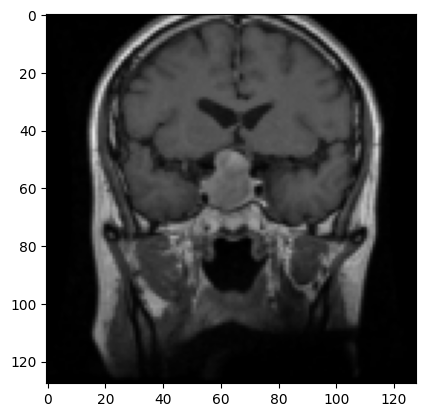

tensor(3)


In [12]:
sample_id = 5

img = images[sample_id].permute(1, 2, 0).numpy()
plt.imshow(img)

plt.show()

print(labels[sample_id])

### Model

In [13]:
model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
model.fc = nn.Linear(in_features=2048, out_features=4)

In [16]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
device = torch.device(os.getenv("DEVICE"))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.01)

In [19]:
train_loss_plot = []
test_loss_plot = []

In [20]:
best_result = np.inf
test_loss_array = []
n_epochs = 15
patience = 3

for epoch in range(n_epochs):

    total_loss = 0
    for X_batch, y_batch in trainloader:

        X_batch = X_batch.to(device,dtype=torch.float32)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)

        loss = criterion(outputs.to(device), y_batch)
        train_loss_plot.append(loss.item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item() 

    test_loss = 0
    with torch.no_grad():  
            
            for X_batch, y_batch in testloader:

                X_batch = X_batch.to(device,dtype=torch.float32)
                y_batch = y_batch.to(device)

                outputs = model(X_batch)
                t_loss = criterion(outputs.to(device), y_batch)
                test_loss_plot.append(t_loss.item())

                test_loss+=t_loss

    loss = total_loss / (len(trainloader))
    loss_test = test_loss / (len(testloader))

    test_loss_array.append(loss_test)

    if loss_test < best_result:
        torch.save(model.state_dict(), "./resnet.pth")

    print(f"Epoch: {epoch}, Train loss: {loss}, Test loss: {loss_test}")

    if len(test_loss_array)>patience+1:
        if not (any(x > (test_loss_array[-1]+0.001) for x in test_loss_array[len(test_loss_array)-patience-1:-1])):
            break

Epoch: 0, Train loss: 1.1884008897468448, Test loss: 1.0174716711044312
Epoch: 1, Train loss: 0.9092755606397986, Test loss: 0.8369162082672119
Epoch: 2, Train loss: 0.7816343670710921, Test loss: 0.7666321396827698
Epoch: 3, Train loss: 0.7140131741762161, Test loss: 0.7047014236450195
Epoch: 4, Train loss: 0.6620480362325907, Test loss: 0.6618208885192871
Epoch: 5, Train loss: 0.6213673250749707, Test loss: 0.6244978904724121
Epoch: 6, Train loss: 0.5951819783076644, Test loss: 0.6198901534080505
Epoch: 7, Train loss: 0.57724590273574, Test loss: 0.5966600775718689
Epoch: 8, Train loss: 0.5508539993315935, Test loss: 0.5818189978599548
Epoch: 9, Train loss: 0.5319118639454246, Test loss: 0.5488312840461731
Epoch: 10, Train loss: 0.5075459135696292, Test loss: 0.5563725829124451
Epoch: 11, Train loss: 0.5155977196991444, Test loss: 0.5507422685623169
Epoch: 12, Train loss: 0.4902582564391196, Test loss: 0.5373381972312927
Epoch: 13, Train loss: 0.46862386888824403, Test loss: 0.527399

In [27]:
model.load_state_dict(torch.load("./resnet.pth"))

<All keys matched successfully>

### Results

<Axes: >

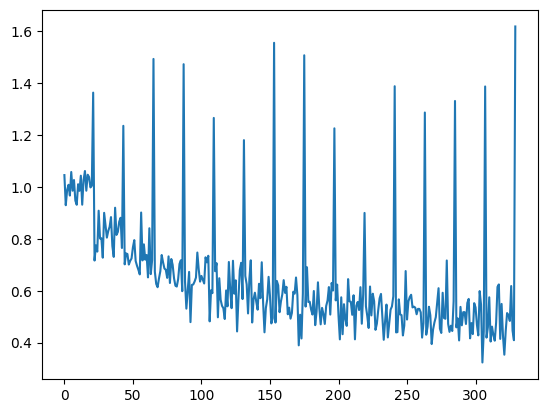

In [28]:
import seaborn as sns

sns.lineplot(data = test_loss_plot)

<Axes: >

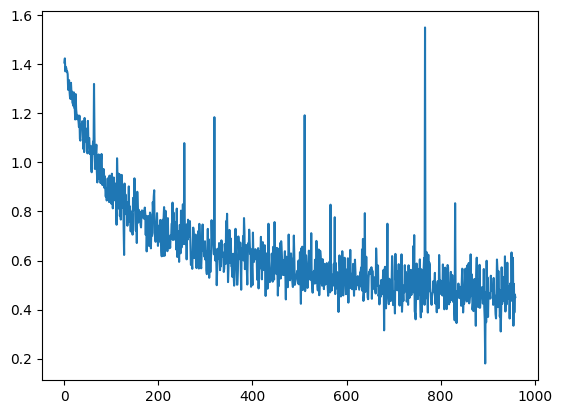

In [29]:
sns.lineplot(data = train_loss_plot)

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [31]:
accuracy = []
f1_scr = []
precision = []
recall=[]

with torch.no_grad():
    
    for X_batch, y_batch in valloader:
        outputs_pred = model(X_batch.to(device))

        _, topi = outputs_pred.topk(1)

        topi=topi.cpu()

        acc = accuracy_score(y_batch,topi.squeeze(-1))
        f1 = f1_score(y_batch,topi.squeeze(-1), average="macro")
        pr = precision_score(y_batch,topi.squeeze(-1), average="macro")
        rec = recall_score(y_batch,topi.squeeze(-1),average="macro")


        accuracy.append(float(acc))
        f1_scr.append(float(f1))
        precision.append(float(pr))
        recall.append(float(rec))


The training process was more time-consuming, and the training process is similar to EfficientNet with a slightly lower results.

In [32]:
print(statistics.mean(accuracy))
print(statistics.mean(f1_scr))
print(statistics.mean(precision))
print(statistics.mean(recall))

0.8323863636363636
0.8203507558633165
0.8230384749760982
0.8281007294182015
